In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertions = list(h5_file[calibration_path].keys())
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = '210422_green_tests/green_testing_210422.h5'
file = path_name + test_file_name

ses1_cals = create_list_of_calibrations_in_node(file, 'session001')

ses2_cals = create_list_of_calibrations_in_node(file, 'session002')

cals = []
for cal in ses1_cals:
    ses_cal = 'session001/' + cal
    cals.append(ses_cal)
for cal in ses2_cals:
    ses_cal = 'session002/' + cal
    cals.append(ses_cal)

# Plot all FTIR calibration curves for 4/22/21, color determined by spectrometer temperature

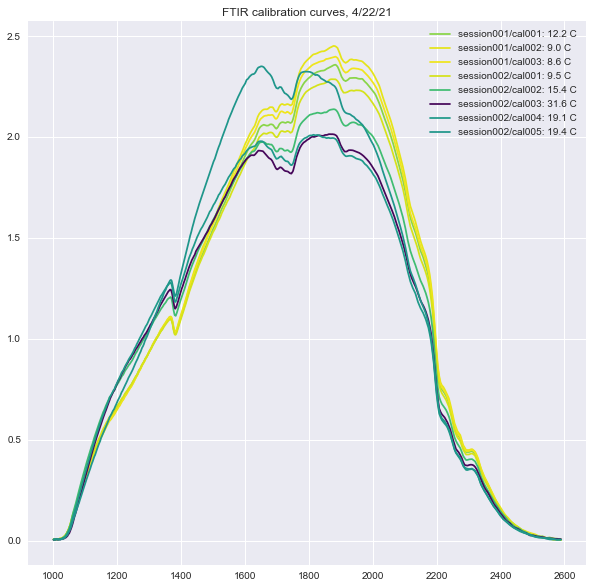

In [4]:
ftir_curves = []
for cal in cals:
    ftir_curve = get_ftir_white_calibration_curve(file, cal)
    ftir_curves.append(ftir_curve)
ftir_cal_temps = []
for cal in cals:
    ftir_temp = get_calibration_temperature(file, cal)
    ftir_cal_temps.append(ftir_temp)
ftir_waves = get_ftir_wavelength_vector(file, cals[0])
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR calibration curves, 4/22/21")
for calibration in cals:
    cal_temp = get_calibration_temperature(file, calibration)
    color = plt.cm.viridis((cal_temp - 32.0)/(8.0 - 32.0))
    ftir_cal = get_ftir_white_calibration_curve(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ftir_cal, color=color, label=f'{calibration}: {cal_temp:0.1f} C')
ax.legend()
plt.show()
plt.close()

# Plot all FTIR calibration curves, 4/22/21, color determined by order of acquisition

The large difference in shape between the curve for session002/cal004 and session002/cal005 is because during session002/cal004 the light source was heated up, but not the spectrometer.

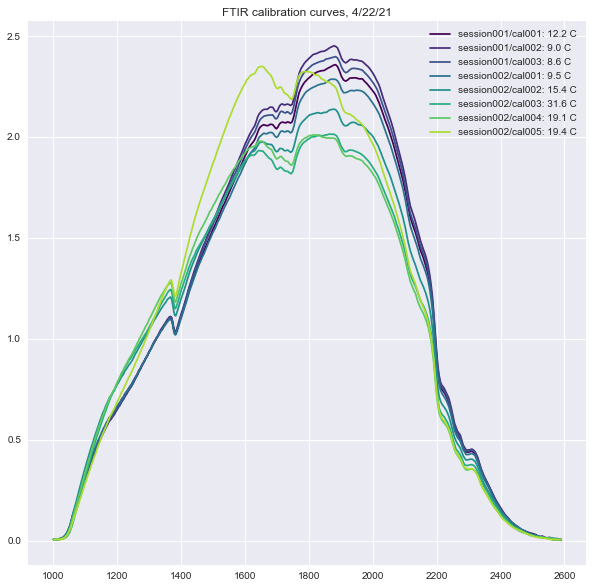

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR calibration curves, 4/22/21")
for calibration in cals:
    index = cals.index(calibration)
    cal_temp = get_calibration_temperature(file, calibration)
    color = plt.cm.viridis(index/len(cals))
    ftir_cal = get_ftir_white_calibration_curve(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ftir_cal, color=color, label=f'{calibration}: {cal_temp:0.1f} C')
ax.legend()
plt.show()
plt.close()

In [6]:
def append_session_insertion_strings(insertion_list, session_string, insertion_min, insertion_max):
    for i in range(insertion_min, insertion_max + 1):
        string = f'{session_string}/ins{i:03d}'
        insertion_list.append(string)

# White blank spectra, cold spectrometer/light source

During the acquisition of these spectra, the rig was placed outside the garage in the cold outside air.  Thus the spectrometer's temperature was cooling during the acquistion of these spectra.  The light source temperature was also affected by being outside.

## Raw spectra

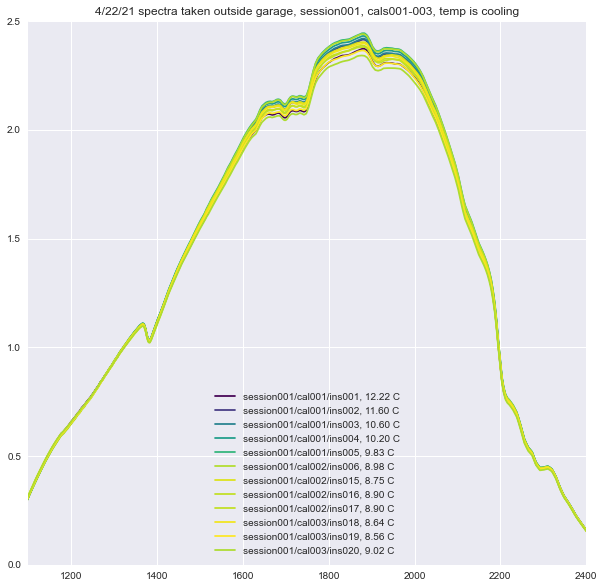

In [7]:
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.5)
ax.set_title("4/22/21 spectra taken outside garage, session001, cals001-003, temp is cooling")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra, only cal001.

These were the first spectra acquired.  The spectrometer was trending downward during this time.

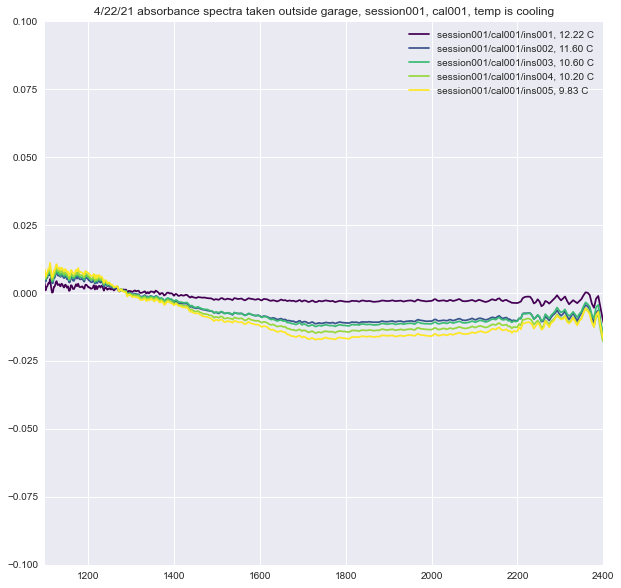

In [8]:
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
#append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
#append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
#append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 absorbance spectra taken outside garage, session001, cal001, temp is cooling")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra, cal002

During this calibration the temperature of the spectrometer had stabilized.

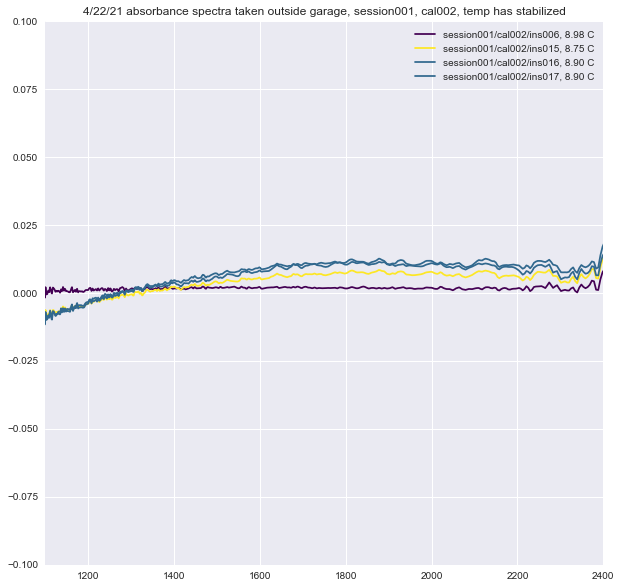

In [9]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
#append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 absorbance spectra taken outside garage, session001, cal002, temp has stabilized")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra, cal003

The spectrometer was re-calibrated and three more sets of white blank spectra were taken before the rig was brought in to the garage again.  The temperature of the spectrometer remained basically stable during this period.

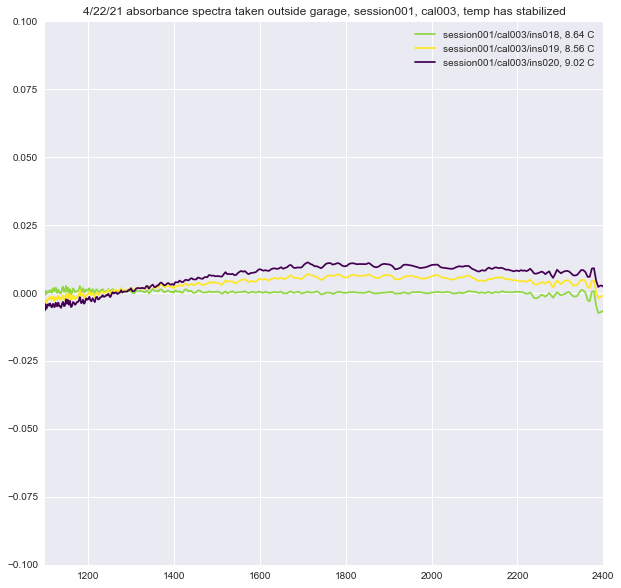

In [10]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 absorbance spectra taken outside garage, session001, cal003, temp has stabilized")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Temperature by raw value at 1649 nm

This plot shows the temperature of the spectrometer by the raw value of the curve at 1649 nm during the three calibrations while the rig was outdoors in the cold.

1649 nm was chosen mostly because it appeared that the spread between spectra was relatively large at that wavelength.

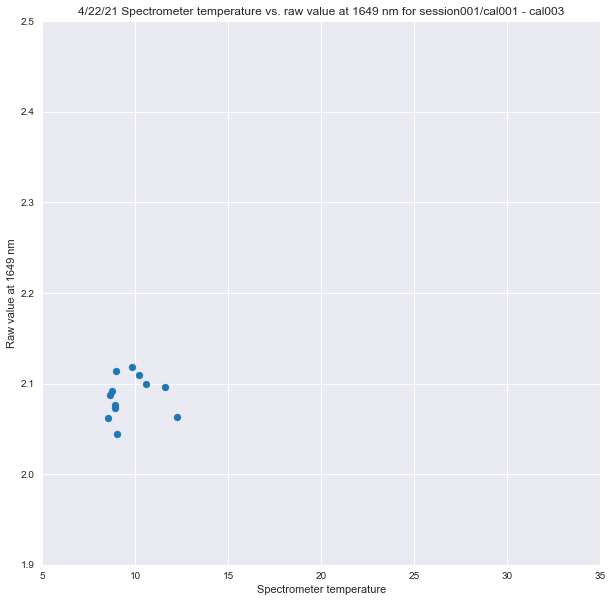

In [11]:
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

fig, ax = plt.subplots(figsize=(10, 10))
wavelength = 1649
wavelength_index = list(ftir_waves.astype(int)).index(wavelength)
ax.set_ylabel(f"Raw value at {wavelength} nm")
ax.set_xlabel("Spectrometer temperature")
ax.set_ylim(1.9, 2.5)
ax.set_xlim(5, 35)
ax.set_title(f"4/22/21 Spectrometer temperature vs. raw value at {wavelength} nm for session001/cal001 - cal003")
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)    
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    raw_value = ins_raw.mean(axis=0)[wavelength_index]    
    ax.scatter(x=insertion_temp, y=raw_value, color='tab:blue')
plt.show()
plt.close()

# White blank spectra, naturally warming spectrometer/light source

The rig was brought back inside the garage and left to warm up natrually during this group of spectra. The temperature of both spectrometer and light source could be affected.

# Raw spectra

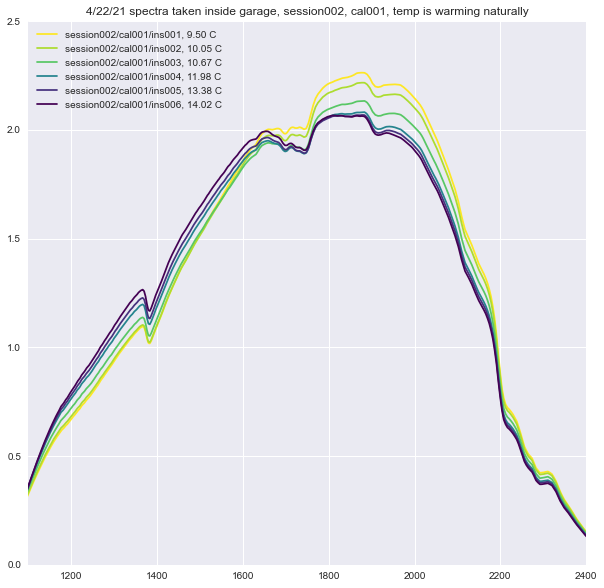

In [12]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.5)
ax.set_title("4/22/21 spectra taken inside garage, session002, cal001, temp is warming naturally")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra

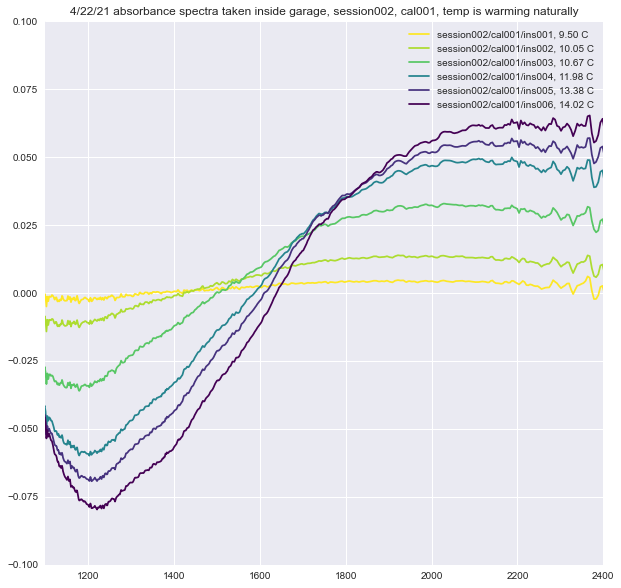

In [13]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 absorbance spectra taken inside garage, session002, cal001, temp is warming naturally")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Temperature by raw value at 1649 nm

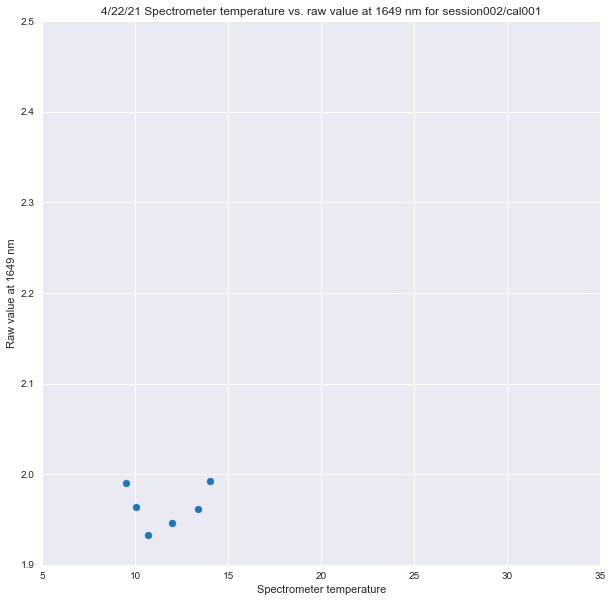

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
wavelength = 1649
wavelength_index = list(ftir_waves.astype(int)).index(wavelength)
ax.set_ylabel(f"Raw value at {wavelength} nm")
ax.set_xlabel("Spectrometer temperature")
ax.set_title(f"4/22/21 Spectrometer temperature vs. raw value at {wavelength} nm for session002/cal001")
ax.set_xlim(5, 35)
ax.set_ylim(1.9, 2.5)
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)    
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    raw_value = ins_raw.mean(axis=0)[wavelength_index]    
    ax.scatter(x=insertion_temp, y=raw_value, color='tab:blue')
plt.show()
plt.close()

# White blank spectra, acquired while only the spectrometer was warmed up.

After the rig had acclimated to the temperature inside the garage, I warmed up the spectrometer using a hair dryer while protecting the light source from the warm air.

The hair dryer was not applied while the spectra were being acquired, only between acquisition of groups of spectra.

## Raw spectra

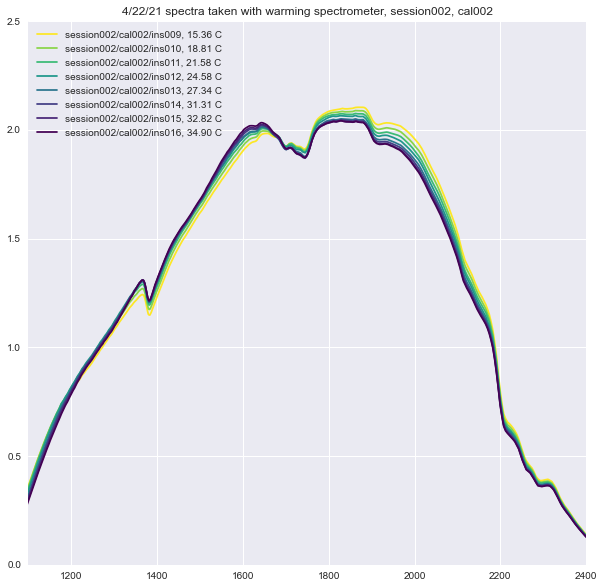

In [15]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.5)
ax.set_title("4/22/21 spectra taken with warming spectrometer, session002, cal002")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra

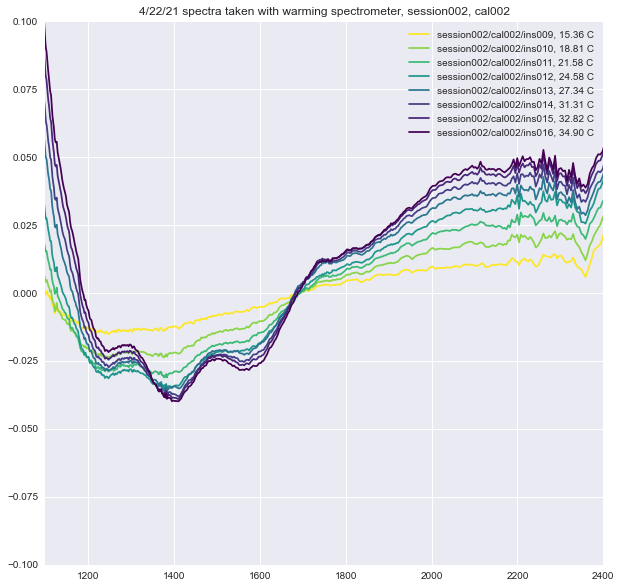

In [16]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 spectra taken with warming spectrometer, session002, cal002")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Temperature by raw value at 1649 nm

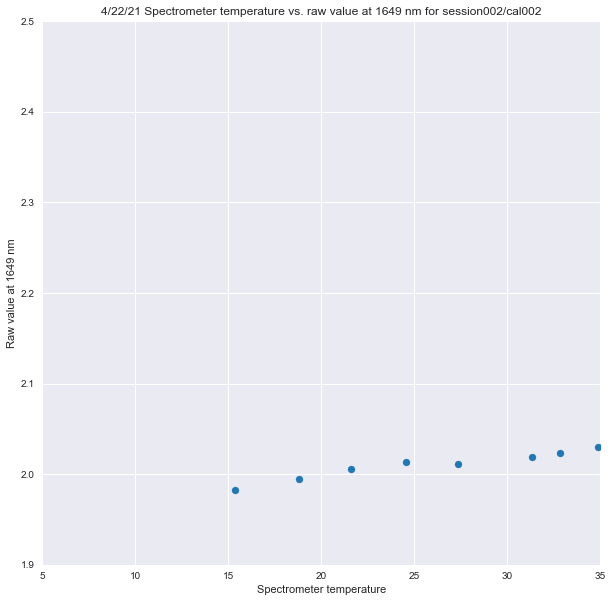

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
wavelength = 1649
wavelength_index = list(ftir_waves.astype(int)).index(wavelength)
ax.set_ylabel(f"Raw value at {wavelength} nm")
ax.set_xlabel("Spectrometer temperature")
ax.set_title(f"4/22/21 Spectrometer temperature vs. raw value at {wavelength} nm for session002/cal002")
ax.set_xlim(5, 35)
ax.set_ylim(1.9, 2.5)
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)    
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    raw_value = ins_raw.mean(axis=0)[wavelength_index]    
    ax.scatter(x=insertion_temp, y=raw_value, color='tab:blue')
plt.show()
plt.close()

# White blank spectra taken while spectrometer cooling down after being heated.

I allowed the spectrometer to cool again after heating it up.

Note that these curve are *not* at all the same as the curves obtained at the same temperature as the spectrometer was being heated.  I know no reason why the light source should have changed temperature much during either of these sessions, as the rig was located in the garage with the garage door closed.

There was a gap in time between the first of these spectra and the rest of them while I acquired spectra of other targets.

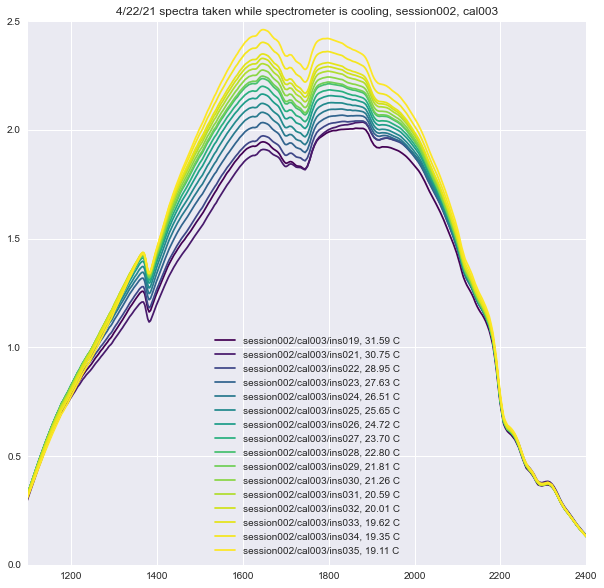

In [18]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.5)
ax.set_title("4/22/21 spectra taken while spectrometer is cooling, session002, cal003")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra

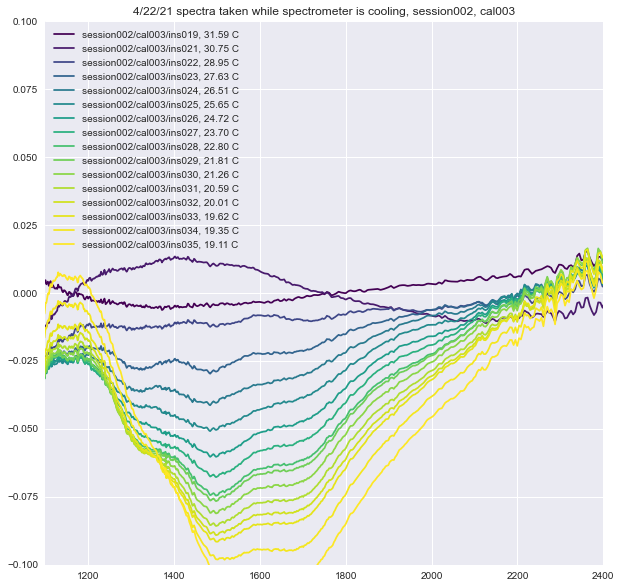

In [19]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
# append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 spectra taken while spectrometer is cooling, session002, cal003")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Temperature by raw value at 1649 nm

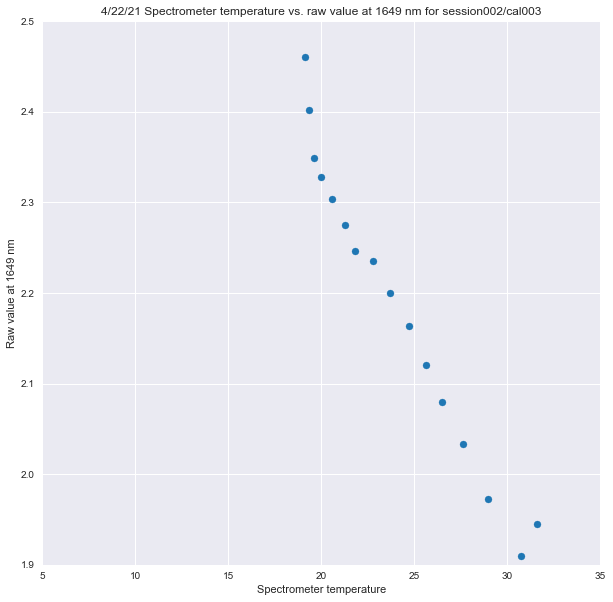

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
wavelength = 1649
wavelength_index = list(ftir_waves.astype(int)).index(wavelength)
ax.set_ylabel(f"Raw value at {wavelength} nm")
ax.set_xlabel("Spectrometer temperature")
ax.set_title(f"4/22/21 Spectrometer temperature vs. raw value at {wavelength} nm for session002/cal003")
ax.set_ylim(1.9, 2.5)
ax.set_xlim(5, 35)
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)    
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    raw_value = ins_raw.mean(axis=0)[wavelength_index]    
    ax.scatter(x=insertion_temp, y=raw_value, color='tab:blue')
plt.show()
plt.close()

# White blank spectra, light source being warmed

During this group of spectra, I warmed the light source with the hair dryer between acquisitions while protected the spectrometers from the warm air.  I do not know the exact temperature of the light source, but it should have warmed with time during this group.  The spectrometer temperature remained essentially steady,

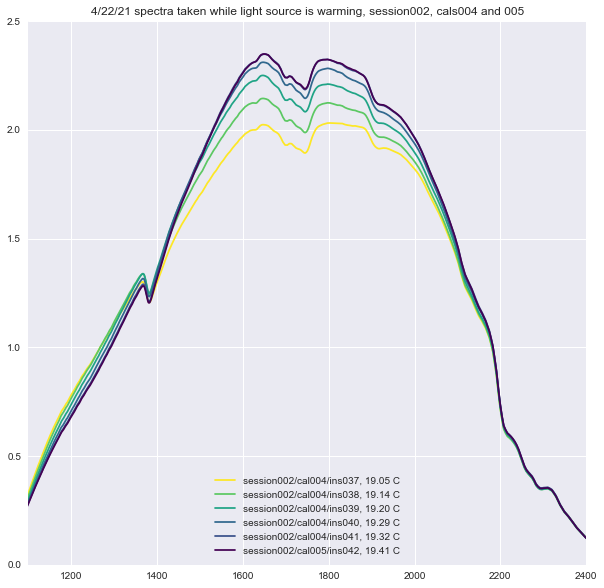

In [21]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.5)
ax.set_title("4/22/21 spectra taken while light source is warming, session002, cals004 and 005")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Absorbance spectra

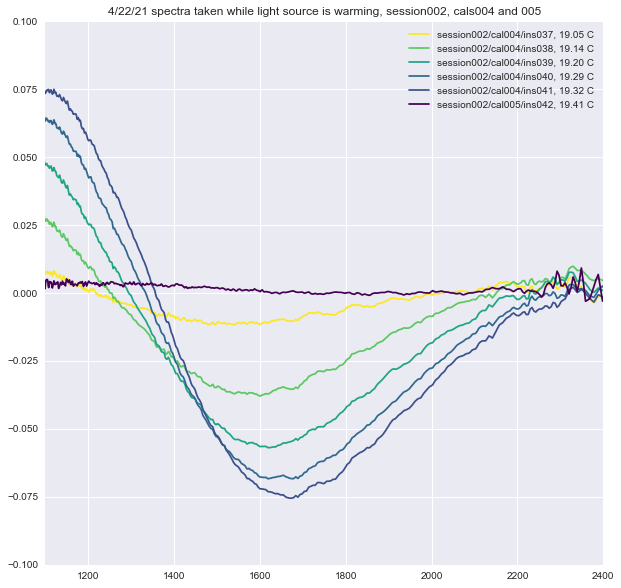

In [22]:
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
# append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.1, 0.1)
ax.set_title("4/22/21 spectra taken while light source is warming, session002, cals004 and 005")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

## Temperature by raw value at 1649 nm

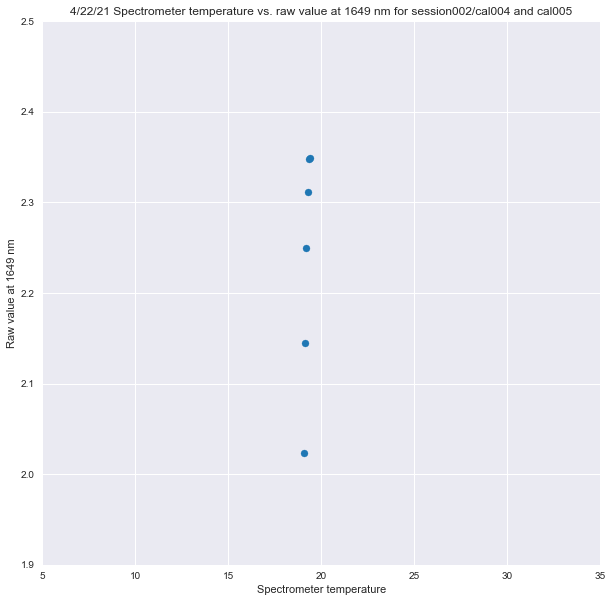

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
wavelength = 1649
wavelength_index = list(ftir_waves.astype(int)).index(wavelength)
ax.set_ylabel(f"Raw value at {wavelength} nm")
ax.set_xlabel("Spectrometer temperature")
ax.set_xlim(5, 35)
ax.set_ylim(1.9, 2.5)
ax.set_title(f"4/22/21 Spectrometer temperature vs. raw value at {wavelength} nm for session002/cal004 and cal005")
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)    
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    raw_value = ins_raw.mean(axis=0)[wavelength_index]    
    ax.scatter(x=insertion_temp, y=raw_value, color='tab:blue')
plt.show()
plt.close()

# All the white blank spectra

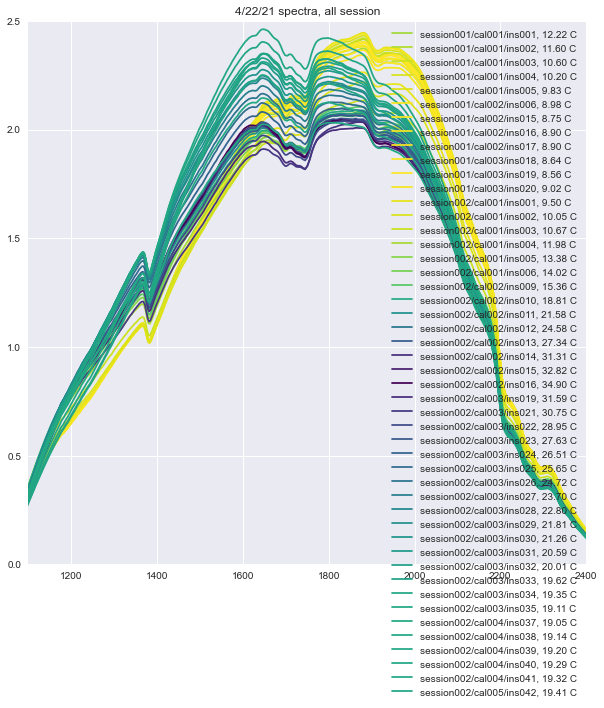

In [24]:
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 6, 6)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 15, 17)
append_session_insertion_strings(white_blank_ins, 'session001/cal003', 18, 20)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 6)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 9, 16)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 19, 19)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 21, 35)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 37, 41)
append_session_insertion_strings(white_blank_ins, 'session002/cal005', 42, 42)

insertion_temps = []
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
insertion_temps

temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.5)
ax.set_title("4/22/21 spectra, all session")

for insertion in white_blank_ins:
    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)

    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

In [25]:
session_dict = {'session001/cal001': ('tab:blue', 'cooling outside'), 
                 'session001/cal002': ('tab:blue', 'cooling outside'), 
                 'session001/cal003':('tab:blue', 'cooling outside'), 
                 'session002/cal001':('tab:red', 'warming naturally'),
                'session002/cal002': ('tab:orange', 'heating spectrometer only'), 
                 'session002/cal003': ('tab:purple', 'spectrometer cooling down'), 
                 'session002/cal004':('tab:green', 'heating light source only'), 
                 'session002/cal005':('tab:green', 'heating light source only')}

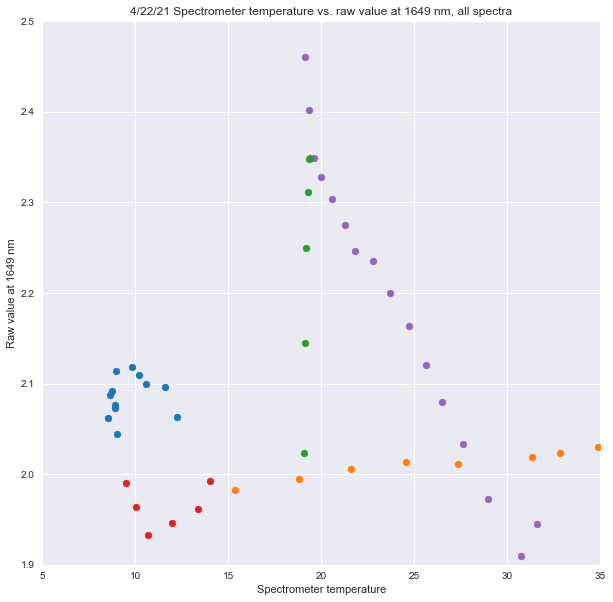

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
wavelength = 1649
wavelength_index = list(ftir_waves.astype(int)).index(wavelength)
ax.set_ylabel(f"Raw value at {wavelength} nm")
ax.set_xlabel("Spectrometer temperature")
ax.set_xlim(5, 35)
ax.set_ylim(1.9, 2.5)
ax.set_title(f"4/22/21 Spectrometer temperature vs. raw value at {wavelength} nm, all spectra")
for insertion in white_blank_ins:
    insertion_temp = get_insertion_temperature(file, insertion)    
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    raw_value = ins_raw.mean(axis=0)[wavelength_index] 
    color = session_dict[insertion[:17]][0]
    label = session_dict[insertion[:17]][1]
    ax.scatter(x=insertion_temp, y=raw_value, color=color, label=label)
# ax.legend()
plt.show()
plt.close()